# Severity of adverse reactions in pediatric patients

In [1]:
import collect_data 
import clean_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer

url_base = "https://api.fda.gov/drug/event.json?search=receivedate:[20030101+TO+20200528]"

## Collecting the pediatric dataset

We will first collect the data. We will initially collect only data for 'children' i.e. category 3 as reported in the database. This does not include neonates, infants or adolescents.

Given the total number of children in the database (35,000), we will initially restrict our analyses to the first 5000, before later expanding the sample. 

In [2]:
n_reports = 5000

# collect pediatric data from database and normalise
raw_pediatric = collect_data.collect_pediatric_data(n_reports)
raw_pediatric.reset_index(drop=True, inplace=True)
flat_pediatric = collect_data.flatten_dataframe(raw_pediatric)

## Cleaning the data

We clean the data to remove unecessary/undesired columns, impute missing values and remove columns with a high fraction of missing values, remove duplicates, format types appropriately, and filter any outliers.

In [9]:
#drop duplicates
clean_pediatric = clean_data.drop_unnecessary_columns(flat_pediatric)
clean_pediatric = clean_data.fill_seriousness_nan(clean_pediatric)
clean_pediatric = clean_data.remove_nan_columns(clean_pediatric, 40)
clean_pediatric = clean_data.fix_data_types(clean_pediatric)
clean_pediatric = clean_data.reformat_onsetage(clean_pediatric)
clean_pediatric = clean_data.remove_outliers(clean_pediatric)
pediatric_data = clean_pediatric.reset_index()

Examine the dataset by eye to look for anomalies and problems.

In [10]:
pediatric_data.describe()

,index,reporttype,serious,primarysource.qualification,patient.patientsex,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdeath,seriousnessdisabling,seriousnesscongenitalanomali,reactionoutcome,patient.patientonsetageyear
count,5000.000000,5000.000000,5000.000000,4983.000000,4039.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4879.000000,0.0
mean,2499.500000,1.257400,1.464000,3.491070,1.331270,0.365200,0.166400,0.017800,0.048400,0.006200,0.003200,4.598073,NaN
std,1443.520003,0.450317,0.498752,1.702912,0.470728,0.481534,0.372477,0.132237,0.214631,0.078503,0.056484,1.999632,NaN
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
25%,1249.750000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,NaN
50%,2499.500000,1.000000,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,NaN
75%,3749.250000,2.000000,2.000000,5.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,NaN
max,4999.000000,4.000000,2.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,NaN


We will now handle any remaining missing data by imputing a new category 'unknown' for the categorical data, and applying a 'mean' or 'most frequent' strategy to the numerical data.


## Exploratory Data Analysis - Pediatric Dataset

Similar to our analysis for the full database (presented in the [Exploring_OpenFDA_Adverse_Reactions notebook](https://github.com/ambevan/OpenFDA_Case_Study/blob/master/Exploring_OpenFDA_Adverse_Reactions.ipynb)), we can now perform some basic analysis and exploration of the cleaned pediatric dataset before building a more sophisticated model. We are predominantly interested in the severity of the adverse effect and so we start by exploring this feature.

We can see that the fraction of reported serious adverse responses is similar to the entire population (54% compared to 59%). Of those where the nature of the serious reponse is reported, the majority (60%) report a response that did not result in death, disability, congenital anomali, a threat to lif or hospitalisation.

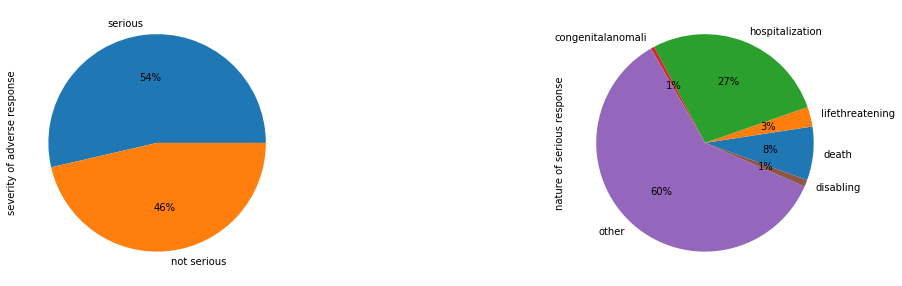

In [69]:
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,5))
pediatric_data.serious.value_counts().plot.pie(labels=['serious','not serious'], ax=ax1, autopct='%1.0f%%');
ax1.set_ylabel('severity of adverse response');

seriousness_col_names = ['seriousnessdeath',
                         'seriousnesslifethreatening',
                         'seriousnesshospitalization', 
                         'seriousnesscongenitalanomali',
                         'seriousnessother',
                         'seriousnessdisabling'
                         ]
labels = [item.replace('seriousness','') for item in seriousness_col_names]
df_serious = pediatric_data[seriousness_col_names]
df_serious.sum().plot.pie(ax=ax2, autopct='%1.0f%%', labels=labels, startangle=-20)
ax2.set_ylabel('nature of serious response');

Two different but comparable metrics exist within the database that give an indication of severity. We can gain some undersading of the accuracy of teh data by comparing these metrics. We know whether the outcome was classified as 'serious' or 'not serious'. We also have the nature of the outcome as falling into one of these categories:

* 1 = Recovered/resolved
* 2 = Recovering/resolving
* 3 = Not recovered/not resolved
* 4 = Recovered/resolved with sequelae (consequent health issues)
* 5 = Fatal
* 6 = Unknown

We can examine the relative frequencies of these outcomes in our data (ignoring any blanks or unknowns).

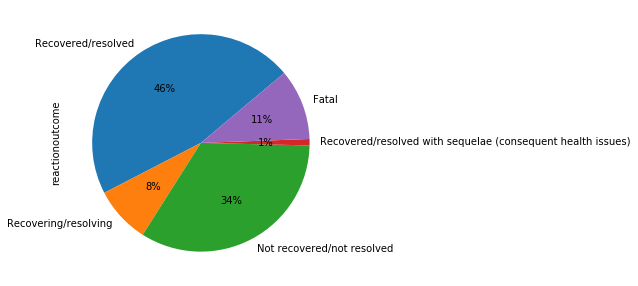

In [94]:
outcome_df = pediatric_data.reactionoutcome.value_counts()
outcome_df.sort_index(inplace=True)
labels_dict = {1 : 'Recovered/resolved',
               2 : 'Recovering/resolving',
               3 : 'Not recovered/not resolved',
               4 : 'Recovered/resolved with sequelae (consequent health issues)',
               5 : 'Fatal',
               6 : 'Unknown'
              }
ax1 = outcome_df[outcome_df.index != 6].plot.pie(autopct='%1.0f%%', labels=labels_dict.values(), figsize=(5,5), startangle=40);                 

In [98]:
pediatric_data.isna().sum()

index                              0
reporttype                         0
occurcountry                      40
serious                            0
primarysource.qualification       17
patient.patientsex               961
seriousnessother                   0
seriousnesshospitalization         0
seriousnesslifethreatening         0
seriousnessdeath                   0
seriousnessdisabling               0
seriousnesscongenitalanomali       0
reactionoutcome                  121
reactionmeddrapt                   0
route                           1038
patient.patientonsetageyear     2405
dtype: int64

## Build a model